In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# micrograd: implement backprop
#   Keep track of node-structure in forward pass, auotmatically compute gradients in backward pass
#   base on chain rule.

In [3]:
def f(x):
    return 3*x**2 - 4*x + 5

In [4]:
f(3.0)

20.0

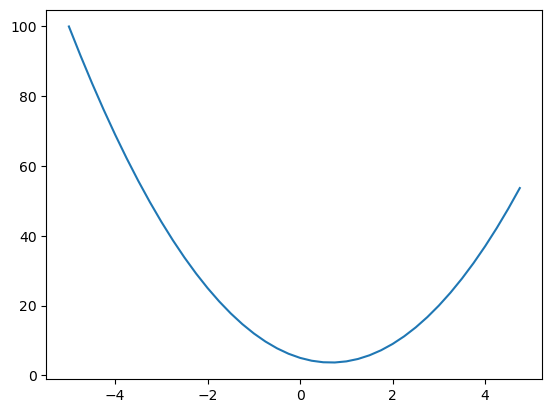

In [5]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

In [6]:
# if we nudge x a little bit, how much does f(x) change in response?

h = 0.00001 # the nedge

# plug in different x to see how f(x) changes in response
# NOTE: the actual value of f(x) doesn't matter much, we care only about the CHANGE of f(x)
x = 0.85
f(x)

3.7674999999999996

In [7]:
# how does the chagne in f(x) compare with the change in x? ie. if I take some
#   step in x, how much does f(x) change in that step?
#   what is ratio btw change in x and the change in f(x) -- that rate is called derivative!!
(f(x + h) - f(x)) / h

1.1000300000230112

In [8]:
h = 0.0001

# inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
a += h
d2 = a*b + c

print('d1', d1)
print('d2', d2)
print('slope', (d2 - d1)/h)

d1 4.0
d2 3.999699999999999
slope -3.000000000010772


In [9]:
from graphviz import Digraph

def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left ot right

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        dot.node(name = uid, label = "{ %s | data %.4f | %.3f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            # if node is a result of an operation, create an op node for it
            dot.node(name = uid + n._op, label = n._op)
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

In [110]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label
    
    def __repr__(self):
        return f'Value(label={self.label} | data={self.data})'

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, _children=(self, other), _op='+')
        def _backward():
            self.grad += out.grad
            other.grad += out.grad
        out._backward = _backward

        return out

    def __radd__(self, other):
        return self + other

    def __neg__(self):
        return self * -1
    
    def __sub__(self, other):
        return self + (-other)

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        o = Value(self.data * other.data, _children=(self, other), _op='*')
        def _backward():
            self.grad += other.data * o.grad
            other.grad += self.data * o.grad
        o._backward = _backward
        return o

    def __rmul__(self, other):
        return self * other
    
    def __truediv__(self, other):
        return self * other**-1

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float for now"
        out = Value(self.data**other, (self,), f'**{other}')

        def _backward():
            self.grad += other * (self.data**(other-1)) * out.grad
        out._backward = _backward

        return out

    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self,), 'exp')

        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward

        return out

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
        out = Value(t, (self,), 'tanh')

        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward

        return out

    def backward(self):

        graph = []
        visited = set()
        def _build_graph(node):
            if node not in visited:
                visited.add(node)
                for c in node._prev:
                    _build_graph(c)
                graph.append(node)

        _build_graph(self)

        self.grad = 1.0
        for node in reversed(graph):
            node._backward()

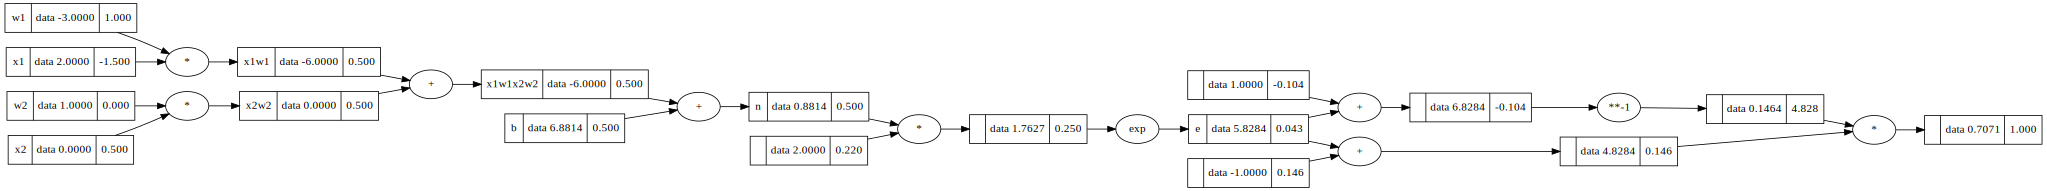

In [61]:
# single neuron

# input x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of the neuron
b = Value(6.8813735870195432, label='b')

x1w1 = x1 * w1; x1w1.label = 'x1w1'
x2w2 = x2 * w2; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1x2w2'
n = x1w1x2w2 + b; n.label = 'n'

# o = n.tanh()
e = (2*n).exp(); e.label = 'e'
o = (e - 1) / (e + 1)

o.backward()
draw_dot(o)

In [214]:
a = Value(2.0, label='a')
b = Value(5.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d * f
L.label = 'L'
L.backward()

visiting Value(label=L | data=-40.0)
visiting Value(label=d | data=20.0)
visiting Value(label=c | data=10.0)
visiting Value(label=e | data=10.0)
visiting Value(label=a | data=2.0)
visiting Value(label=b | data=5.0)
visiting Value(label=f | data=-2.0)
I am Value(label=d | data=20.0)
 > update grad for Value(label=e | data=10.0)
 > update grad for Value(label=c | data=10.0)
calling backward for Value(label=e | data=10.0)!


In [215]:
# this is a small example of manual backprop lol

# what is nudge of L respect to itself, ie. dL/dL? just 1
L.grad = 1.0

# what is dL/dd and dL/df?
# for mult node of c=a*b, the grad of dc/da = b, dc/db = a
f.grad = 4.0
d.grad = -2.0

# what is dL/dc?
# we know d=c+e, and we know dL/dd = 4.0
# additionally, the local grad of add node is always 1, ie. dd/dc = 1
# so applying chain rule, we get dL/dc = dL/dd * dd/dc = 4.0 * 1 = 4.0
c.grad = 4.0

# NOTE: add node just "routes" the gradient to its children!!

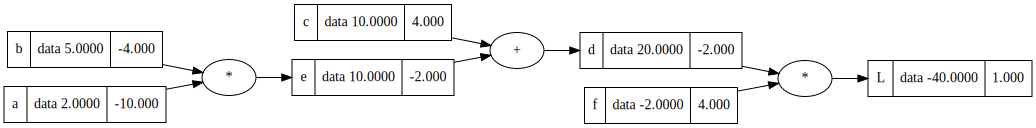

In [171]:
draw_dot(L)

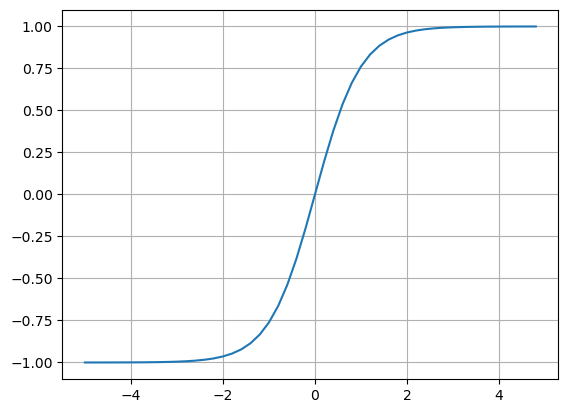

In [ ]:
# mannul backprop throuh a neuron

# tanh -- squashing very pos and neg values
plt.plot(np.arange(-5, 5, 0.2), np.tanh(np.arange(-5, 5, 0.2))); plt.grid()

In [172]:
# single neuron

# input x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of the neuron
b = Value(6.8813735870195432, label='b')

x1w1 = x1 * w1; x1w1.label = 'x1w1'
x2w2 = x2 * w2; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1x2w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh()

o.backward()

# # manual bakckprop
# o.grad = 1.0
# n.grad = 0.5
# b.grad = 0.5
# x1w1x2w2.grad = 0.5
# x2w2.grad = 0.5
# x1w1.grad = 0.5
# w1.grad = x1w1.grad * x1.data
# x1.grad = x1w1.grad * w1.data
# w2.grad = x2w2.grad * x2.data
# x2.grad = x2w2.grad * w2.data

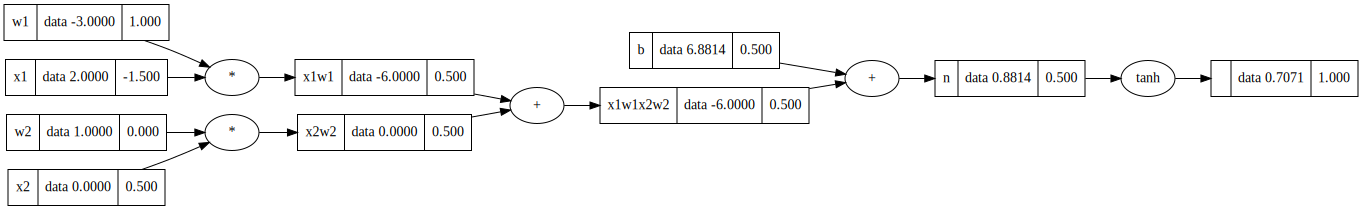

In [173]:
draw_dot(o)

In [51]:
import torch

In [56]:
x1 = torch.tensor([2.0]).double();               x1.requires_grad = True
x2 = torch.tensor([0.0]).double();               x2.requires_grad = True
w1 = torch.tensor([-3.0]).double();              w1.requires_grad = True
w2 = torch.tensor([1.0]).double();               w2.requires_grad = True
b = torch.tensor([6.8813735870195432]).double(); b.requires_grad = True
n = x1 * w1 + x2 * w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('----')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
----
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [147]:
import random

class Neuron:
    def __init__(self, nin: int):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))

    def __call__(self, x: list):
        # w * x + b
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out

    def parameters(self):
        return self.w + [self.b]

class Layer:
    def __init__(self, nin: int, nout: int):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        outs = [neuron(x) for neuron in self.neurons]
        return outs[0] if len(outs) == 1 else outs

    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:
    def __init__(self, nin: int, nouts: list):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x 

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]


Value(label= | data=-0.39322057377383063)

In [148]:

x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(label= | data=0.9358070653539167)

In [151]:
len(n.parameters())

41

In [190]:
n = MLP(3, [4, 4, 1])

In [197]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0]
ypred = [n(x) for x in xs]
ypred

[Value(label= | data=0.5474304981356395),
 Value(label= | data=0.8149816512025301),
 Value(label= | data=-0.06928643737692895),
 Value(label= | data=0.38391294440813395)]

In [198]:
# loss function
loss = sum((ypred_i - y_i)**2 for ypred_i, y_i in zip(ypred, ys))
loss

Value(label= | data=4.744768543938003)

In [199]:
loss.backward()

In [200]:
n.layers[0].neurons[0].w[0].grad

-0.057191093144209254

In [201]:
n.layers[0].neurons[0].w[0].data

-0.8480830837191403

In [202]:
for p in n.parameters():
    p.data += -0.01 * p.grad

In [221]:
# init nn
n = MLP(3, [4, 4, 1])

In [226]:
# training data
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0]

for i in range(20):

    # forward pass
    ypred = [n(x) for x in xs]
    loss = sum((ypred_i - y_i)**2 for ypred_i, y_i in zip(ypred, ys))
    print(f"step {i} | loss={loss.data}")

    # backward pass
    for p in n.parameters():
        p.grad = 0.0
    loss.backward()

    # update
    for p in n.parameters():
        p.data += -0.05 * p.grad


step 0 | loss=0.01250725027739926
step 1 | loss=0.012336689995435243
step 2 | loss=0.01217045751331155
step 3 | loss=0.012008393167506078
step 4 | loss=0.01185034499220455
step 5 | loss=0.011696168262640338
step 6 | loss=0.011545725070502683
step 7 | loss=0.011398883928817972
step 8 | loss=0.011255519403946554
step 9 | loss=0.01111551177255168
step 10 | loss=0.010978746701586953
step 11 | loss=0.01084511494952174
step 12 | loss=0.010714512087181032
step 13 | loss=0.010586838236713926
step 14 | loss=0.010461997827334596
step 15 | loss=0.010339899366592398
step 16 | loss=0.010220455226033216
step 17 | loss=0.010103581440207612
step 18 | loss=0.009989197518067159
step 19 | loss=0.009877226265868837


In [227]:
ypred

[Value(label= | data=0.9582662947226154),
 Value(label= | data=-0.9661348884975923),
 Value(label= | data=-0.9337358895263707),
 Value(label= | data=0.9490319119864461)]